In [1]:
%pylab inline
import pandas as pd
import numpy as np
import fmt

Populating the interactive namespace from numpy and matplotlib


# Homework Set 9

This homework is to price [synthetic CDO](https://en.wikipedia.org/wiki/Synthetic_CDO) using the one factor Gaussian Copula model. 

A synthetic CDO consists of $n$ CDS, the total loss of the portfolio is defned as:

$$ l(t) = \sum_i^n w_i \tilde {\mathbb{1}}_i(t) (1-r_i(t)) $$

where $w_i$ and $r_i(t)$ are the notional weights and recovery rate of the i-th name in the portfolio. The notional weighs sum up to 1: $\sum_i w_i = 1 $. The $ \tilde {\mathbb{1}}_i(t) $ is the default indicator of the i-th name defaulted before time $t$, the default probability is therefore $p_i(t) = \mathbb E[\tilde {\mathbb{1}}_i(t) ]$

For the purpose of this homework, we consider a simplified synthetic CDO that has no coupon payments, therefore the PV of a \$1 notional synthetic CDO tranche with maturity $t$, attachment $a$ and detachment $d$ is:

$$ v(a, d) = \frac{d(t)}{d-a} \min\left((l(t) - a)^+, d-a\right) $$

where $d(t)$ is the discount factor.

The following are the parameters to the synthetic CDO, and a straight forward Monte Carlo pricer:

In [239]:
n = 125
t = 5.
defProbs = 1 - exp(-(np.random.uniform(size=n)*.03)*t)
recovery = 0.4*np.ones(n)
w = 1./n*np.ones(n)
rho = 0.5
discf = .9
npath = 1000

# a list of attachements and detachements, they pair up by elements
attachements = np.array([0, .03, .07, .1, .15, .3])
detachements = np.array([.03, .07, .1, .15, .3, .6])

#portfolio expected loss
el = np.sum(w*defProbs*(1-recovery))
print "portfolio expected loss is ", el

portfolio expected loss is  0.0430353543199


In [240]:
from scipy.stats import norm

class CDO(object) :
    def __init__(self, w, defProbs, recovery, a, d) :
        self.w = w/np.sum(w)
        self.p = defProbs
        self.rec = recovery
        self.rho = rho
        self.a = a
        self.d = d

    def drawDefaultIndicator(self, z, rho) :
        '''return a list of default indicators given common factor z, using one factor Gaussian Copula
        '''
        e = np.random.normal(size=np.shape(self.p))
        x = z*np.sqrt(self.rho) + np.sqrt(1-self.rho)*e
        return np.less(norm.cdf(x), self.p), e

    def portfolioLoss(self, defIndicator) :
        '''compute portfolio loss given default indicators'''
        return np.sum(defIndicator*self.w*(1-self.rec))

    def tranchePV(self, portfLoss, discf) :
        '''compute tranche PV from portfolio loss
        Args:
            portfLoss: the total portfolio loss
            discf: discount factor
        Returns:
            tranche PVs'''
        
        sz = self.d - self.a
        return discf/sz*np.minimum(np.maximum(portfLoss - self.a, 0), sz)

    def drawPV(self, z, rho, discf) :
        ''' compute PV and portfolio Loss conditioned on a common factor z'''
        di, es = self.drawDefaultIndicator(z, rho)
        pfLoss = self.portfolioLoss(di)
        return self.tranchePV(pfLoss, discf), pfLoss, es
    
    
cdo = CDO(w, defProbs, recovery, attachements, detachements)

In [241]:
## price the tranches using simulation
def simCDO(cdo, rho, disc, paths) :
    zs = np.random.normal(size=[paths])
    pv = np.zeros(np.shape(cdo.a))
    pv2 = np.zeros(np.shape(cdo.d))
    for z in zs:
        thisPV, _, _ = cdo.drawPV(z, rho, discf)
        pv += thisPV
        pv2 += thisPV*thisPV
        
    v = pv/paths
    var = pv2/paths - v**2
    return pv/paths, np.sqrt(var/paths)

In [242]:
pv_0, err_0 = simCDO(cdo, rho, discf, npath)
df = pd.DataFrame(np.array([cdo.a, cdo.d, pv_0, err_0]), index=['Attach', 'Detach', 'PV', 'MC err'])

fmt.displayDF(df, fmt='4g')

,0,1,2,3,4,5
Attach,0,0.03,0.07,0.1,0.15,0.3
Detach,0.03,0.07,0.1,0.15,0.3,0.6
PV,0.4649,0.2338,0.1515,0.09798,0.03668,0.002182
MC err,0.01222,0.01152,0.01036,0.008442,0.004771,0.0007649


## Problem 1

Modify the simCDO function to implement the following variance reduction techniques, and show whether the technique is effective:

For this homework, we only apply the variance reduction in the common market factor $z$, you should not change the random number $e$ that were drew with in the drawDefaultIndicator function, i.e., only modify the simCDO code, re-use but do not modify the CDO class. Unless explicitly mentioned, keep the simulation path the same as the base case above.

1. anti-thetic variate, reduce the number of paths by half to account for the 2x increase in computation
1. importance sampling, shift $z$ by -1
1. sobol sequence
1. stratified sampling: sample $z$ using an equal sized grid

Compute the **variance** reduction factor for each technique, and comment on the effectiveness of these variance reduction techniques.

### Solution

1: Antithetic variate:

In [243]:
def simCDO_at(cdo, rho, disc, paths) :
    zs = np.random.normal(size=[paths])
    pv = np.zeros(np.shape(cdo.a))
    pv2 = np.zeros(np.shape(cdo.d))
    for z in zs:
        thisPV = .5*(cdo.drawPV(z, rho, disc)[0] + cdo.drawPV(-z, rho, disc)[0])
        
        pv += thisPV
        pv2 += thisPV*thisPV
        
    v = pv/paths
    var = pv2/paths - v**2
    return pv/paths, np.sqrt(var/paths)

pv_at, err_at = simCDO_at(cdo, rho, discf, npath/2)
df = pd.DataFrame(np.array([cdo.a, cdo.d, pv_at, err_at, (err_0/err_at)**2]), 
                  index=['Attach', 'Detach', 'PV', 'MC err', 'Var Red Factor'])

fmt.displayDF(df, fmt='4g')

,0,1,2,3,4,5
Attach,0,0.03,0.07,0.1,0.15,0.3
Detach,0.03,0.07,0.1,0.15,0.3,0.6
PV,0.4567,0.2512,0.1587,0.08636,0.03208,0.003787
MC err,0.004233,0.009105,0.009018,0.007212,0.004621,0.001129
Var Red Factor,8.334,1.602,1.32,1.37,1.066,0.459


2: Importance sampling:

In [244]:
def simCDO_is(cdo, rho, disc, paths, u) :
    zs = np.random.normal(size=[paths]) + u
    padj = np.exp(-u*zs + .5*u*u)
    padj /= sum(padj)
    
    pv = np.zeros(np.shape(cdo.a))
    for z, q in zip(zs, padj):
        thisPV, _, _ = cdo.drawPV(z, rho, disc)
        pv += thisPV*q
        
    return pv

pvs = [simCDO_is(cdo, rho, discf, npath, -1) for i in range(10)]
pv_is1 = np.mean(pvs, 0)
err_is1 = np.std(pvs, 0)
df = pd.DataFrame(np.array([cdo.a, cdo.d, pv_is1, err_is1, (err_0/err_is1)**2]), 
                  index=['Attach', 'Detach', 'PV', 'MC err', 'Var Red Factor'])
fmt.displayDF(df, fmt='4g')

,0,1,2,3,4,5
Attach,0,0.03,0.07,0.1,0.15,0.3
Detach,0.03,0.07,0.1,0.15,0.3,0.6
PV,0.4582,0.2331,0.147,0.09293,0.03354,0.00297
MC err,0.01897,0.01676,0.01287,0.01022,0.00334,0.0003707
Var Red Factor,0.4148,0.4729,0.6481,0.6821,2.04,4.258


3: Sobol sequence

In [245]:
from sobol_lib import i4_sobol_generate as sobol

def simCDO_ss(cdo, rho, disc, paths, i) :
    zs = norm.ppf(sobol(1, paths, i*paths+1)[0])
    pv = np.zeros(np.shape(cdo.a))
    for z in zs:
        thisPV, _, _ = cdo.drawPV(z, rho, discf)
        pv += thisPV
        
    v = pv/paths
    return pv/paths

pvs = [simCDO_ss(cdo, rho, discf, npath, i) for i in range(10)]
pv_ss = np.mean(pvs, 0)
err_ss = np.std(pvs, 0)

df = pd.DataFrame(np.array([cdo.a, cdo.d, pv_ss, err_ss, (err_0/err_ss)**2]), 
                  index=['Attach', 'Detach', 'PV', 'MC err', 'Var Red Factor'])

fmt.displayDF(df, fmt='4g')

,0,1,2,3,4,5
Attach,0,0.03,0.07,0.1,0.15,0.3
Detach,0.03,0.07,0.1,0.15,0.3,0.6
PV,0.4597,0.2381,0.1488,0.09508,0.03532,0.00317
MC err,0.003108,0.00314,0.00233,0.00138,0.00112,0.0003989
Var Red Factor,15.46,13.47,19.76,37.44,18.14,3.677


4: Stratified Sampling

In [246]:
def simCDO_st(cdo, rho, disc, paths) :
    zs = norm.ppf(np.arange(0., paths)/paths + 0.5/paths)
    pv = np.zeros(np.shape(cdo.a))
    for z in zs:
        thisPV, _, _ = cdo.drawPV(z, rho, discf)
        pv += thisPV
        
    v = pv/paths
    return pv/paths

pvs = [simCDO_st(cdo, rho, discf, npath) for i in range(10)]
pv_st = np.mean(pvs, 0)
err_st = np.std(pvs, 0)

df = pd.DataFrame(np.array([cdo.a, cdo.d, pv_st, err_st, (err_0/err_st)**2]), 
                  index=['Attach', 'Detach', 'PV', 'MC err', 'Var Red Factor'])

fmt.displayDF(df, fmt='4g')

,0,1,2,3,4,5
Attach,0,0.03,0.07,0.1,0.15,0.3
Detach,0.03,0.07,0.1,0.15,0.3,0.6
PV,0.4595,0.2386,0.1481,0.09444,0.035,0.003161
MC err,0.003834,0.002549,0.002203,0.001662,0.0008132,0.0001499
Var Red Factor,10.16,20.45,22.12,25.81,34.42,26.04


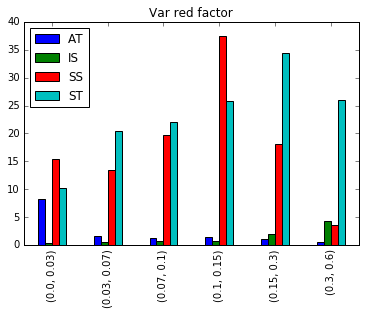

In [247]:
err = pd.DataFrame(np.array([(err_0/x)**2 for x in [err_at, err_is1, err_ss, err_st]]), 
                   index=['AT', 'IS', 'SS', 'ST'], 
                   columns=zip(attachements, detachements))
err.T.plot(kind='bar', title='Var red factor');

## (Extra Credit) Problem 2

Consider a control variate for the problem above. The large pool model assumes that the portfolio is a large homogeneous pool, using the average default rate: $\bar p = \frac{1}{n}\sum_i p_i$. Then the portfolio loss conditioned on market factor $z$ under the large pool model is a determinsitic scalar:

$$ l(z) = (1-r)\Phi\left(\frac{\Phi^{-1}(\bar p) - \sqrt \rho z}{\sqrt{1-\rho}}\right)$$

where $r$ is the constant recovery of all names. $\Phi()$ is the normal CDF function; $\Phi^{-1}()$ is its inverse. The tranche PVs can then be computed from the $l(z)$.

Please investigate if the large pool model can be used as an effective control variate. Does it work better for some tranches?

Hint: to answer this question, you only need to compute the correlation between the actual and control variates. 

### Solution

The large pool model is rather effective.

In [248]:
avgDefProb = np.mean(defProbs)

def simCDO_cv(cdo, rho, disc, paths) :
    zs = np.random.normal(size=[paths]) 
    avgp = np.mean(cdo.p)
    avgr = np.mean(cdo.rec)
    cls = (1-avgr)*norm.cdf((norm.ppf(avgp)-np.sqrt(rho)*zs)/np.sqrt(1-cdo.rho))
 
    pvs = []
    cvs = []
    for z, cl in zip(zs, cls):
        thisPV, _, _ = cdo.drawPV(z, rho, discf)
        thisCV = cdo.tranchePV(cl, discf)
        pvs.append(thisPV)
        cvs.append(thisCV)
        
    corrs = []
    for a, b in zip(np.transpose(pvs), np.transpose(cvs)) :
        corrs.append(np.corrcoef(a, b)[0, 1])
    
    return np.array(corrs), pvs, cvs

corrs1, pvs1, cvs1 = simCDO_cv(cdo, rho, discf, npath)

In [249]:
df = pd.DataFrame(np.array([cdo.a, cdo.d, corrs1, 1./(1-corrs1**2)]), 
                  index=['Attach', 'Detach', 'Correlation', 'Max Var Red'])

fmt.displayDF(df, fmt='4g')

,0,1,2,3,4,5
Attach,0,0.03,0.07,0.1,0.15,0.3
Detach,0.03,0.07,0.1,0.15,0.3,0.6
Correlation,0.9336,0.9559,0.9398,0.9471,0.9729,0.9754
Max Var Red,7.794,11.59,8.561,9.711,18.67,20.56


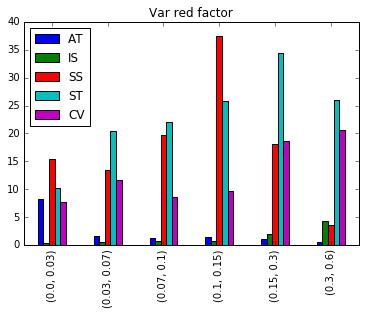

In [250]:
err.ix['CV'] = 1/(1-corrs1**2)
err.T.plot(kind='bar', title='Var red factor'); 